<a href="https://colab.research.google.com/github/MightyManjaly/Datascience_Project/blob/main/Cardio_Vas_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import files
import zipfile
import os

# Upload the zip file
uploaded = files.upload()

Saving resized_train.zip to resized_train.zip


In [ ]:
import zipfile
import os

# List the uploaded files
for filename in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=filename, length=len(uploaded[filename])))

# Unzip the folder
zip_file = list(uploaded.keys())[0]
zip_ref = zipfile.ZipFile(zip_file, 'r')
zip_ref.extractall('/content')
zip_ref.close()




User uploaded file "resized_train.zip" with length 1313030548 bytes


In [ ]:
#-------------2. Load Dataset and Preprocess Images--------------#

# Define dataset paths
#dataset_path = '/Users/mightymanjaly/Documents/DataScienceProject/Cardio_Vascular/resized_train'  # Update with actual dataset directory path
train_images_path = '/content/resized_train'
#test_images_path = os.path.join(dataset_path, '/Users/mightymanjaly/Documents/DataScienceProject/Cardio_Vascular/resized_train_cropped/resized_train_cropped')

# Load and prepare the dataset
filepaths = []
labels = []

for dirname, _, filenames in os.walk(train_images_path):
    for filename in filenames:
        if filename.endswith('.jpeg'):
            filepaths.append(os.path.join(dirname, filename))
            # Assuming folder name is the label
            labels.append(dirname.split('/')[-1])

# Create a DataFrame
df = pd.DataFrame({
    'filepaths': filepaths,
    'labels': labels
})

# Function to crop and convert images to grayscale, then duplicate channels
def preprocess_image(filepath):
    img = load_img(filepath)
    img_array = img_to_array(img)
    height, width, _ = img_array.shape

    # Crop the image to the center square
    crop_size = min(height, width)
    start_x = (width - crop_size) // 2
    start_y = (height - crop_size) // 2
    img_cropped = img_array[start_y:start_y + crop_size, start_x:start_x + crop_size]

    # Convert to grayscale
    img_gray = cv2.cvtColor(img_cropped, cv2.COLOR_RGB2GRAY)

    # Convert single channel grayscale to three channels
    img_gray_3ch = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)
    return img_gray_3ch

# Apply preprocessing and save processed images
processed_dir = '/content/processed_images/'
os.makedirs(processed_dir, exist_ok=True)

processed_filepaths = []
for filepath in df['filepaths']:
    img_gray_3ch = preprocess_image(filepath)
    processed_filepath = os.path.join(processed_dir, os.path.basename(filepath))
    cv2.imwrite(processed_filepath, img_gray_3ch)
    processed_filepaths.append(processed_filepath)

df['processed_filepaths'] = processed_filepaths

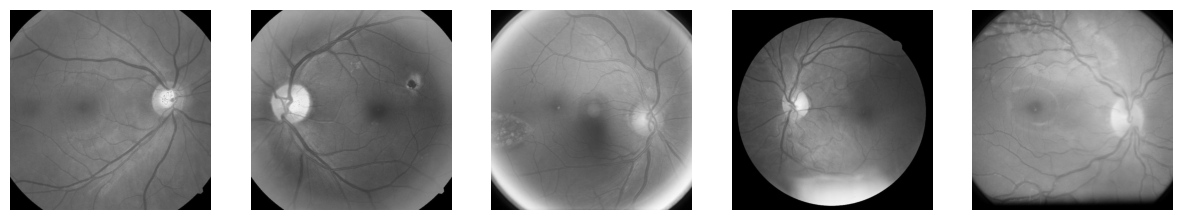

In [ ]:
# ---------------3. Visualize Processed Images------------------#

# Visualize some processed images to check cropping and grayscale conversion
def show_images(filepaths, n=5):
    plt.figure(figsize=(15, 5))
    for i, filepath in enumerate(filepaths[:n]):
        img = load_img(filepath)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# Show some sample images
show_images(df['processed_filepaths'])

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os

# Load the CSV file
csv_file_path = '/content/trainLabels.csv'
labels_df = pd.read_csv(csv_file_path)

# Display the first few rows of the CSV to understand its structure
print("CSV File Preview:")
print(labels_df.head())

# Assuming 'image' and 'level' are the columns in the CSV
labels_df['image'] = labels_df['image'].apply(lambda x: x + '.jpeg')  # Append .jpeg to the image names if not already present

# Merge the CSV data with the processed file paths
df['image'] = df['filepaths'].apply(lambda x: os.path.basename(x))
merged_df = df.merge(labels_df, left_on='image', right_on='image')

# Split the data into training and testing sets
train_df, test_df = train_test_split(merged_df, test_size=0.2, stratify=merged_df['level'], random_state=42)

# Print the number of images in each class for both the training and testing sets
print("Training set class distribution:")
print(train_df['level'].value_counts())

print("Testing set class distribution:")
print(test_df['level'].value_counts())


CSV File Preview:
      image  level
0   10_left      0
1  10_right      0
2   13_left      0
3  13_right      0
4   15_left      1
Training set class distribution:
level
0    20648
2     4234
1     1954
3      698
4      566
Name: count, dtype: int64
Testing set class distribution:
level
0    5162
2    1058
1     489
3     175
4     142
Name: count, dtype: int64


In [ ]:
# -----------------4. Set Up Data Generators----------------#

# Split the DataFrame into training and validation sets
#train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Check the distribution of labels in train and val sets
#print("Train set label distribution:\n", train_df['labels'].value_counts())
#print("Validation set label distribution:\n", val_df['labels'].value_counts())

# Convert the 'level' column to string type
train_df['level'] = train_df['level'].astype(str)
test_df['level'] = test_df['level'].astype(str)

# Define image data generators with increased data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='processed_filepaths',
    y_col='level',
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    test_df,
    x_col='processed_filepaths',
    y_col='level',
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

Found 28100 validated image filenames belonging to 5 classes.
Found 7026 validated image filenames belonging to 5 classes.


In [ ]:
# ----------------5. Build and Compile Model------------------------#

from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Load the InceptionV3 model with pre-trained ImageNet weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with a smaller learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
# --------------------6. Train the Model------------------------#

from tensorflow.keras.callbacks import EarlyStopping

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size,
    epochs=15,  # Increase number of epochs
    callbacks=[early_stopping]
)

Epoch 1/15
297/878 [=========>....................] - ETA: 3:01:24 - loss: 14.1065 - accuracy: 0.7454

KeyboardInterrupt: 

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split



# Step 2: List processed images and save to CSV
processed_dir = '/content/drive/MyDrive/processed_images'

# List all processed image files
processed_filepaths = []
for filename in os.listdir(processed_dir):
    if filename.endswith('.jpeg'):
        processed_filepaths.append(os.path.join(processed_dir, filename))

# Create a DataFrame with the file paths
df = pd.DataFrame({
    'processed_filepaths': processed_filepaths
})

# Save the DataFrame to a CSV file
processed_df_path = '/content/drive/MyDrive/processed_image_data.csv'
df.to_csv(processed_df_path, index=False)

print("Processed image paths saved to CSV.")

# Step 3: Load the CSV file containing processed image paths
df = pd.read_csv(processed_df_path)

# Load the CSV file with labels
csv_file_path = '/content/drive/MyDrive/trainLabels.csv'
labels_df = pd.read_csv(csv_file_path)

# Display the first few rows of the CSV to understand its structure
print("CSV File Preview:")
print(labels_df.head())

# Step 4: Merge with labels
# Assuming 'image' and 'level' are the columns in the CSV
labels_df['image'] = labels_df['image'].apply(lambda x: x + '.jpeg')  # Append .jpeg to the image names if not already present

# Extract image names from file paths in df
df['image'] = df['processed_filepaths'].apply(lambda x: os.path.basename(x))

# Merge the CSV data with the processed file paths
merged_df = df.merge(labels_df, left_on='image', right_on='image')

# Step 5: Split data into training and testing sets
train_df, test_df = train_test_split(merged_df, test_size=0.2, stratify=merged_df['level'], random_state=42)

# Print the number of images in each class for both the training and testing sets
print("Training set class distribution:")
print(train_df['level'].value_counts())

print("Testing set class distribution:")
print(test_df['level'].value_counts())

# Step 6: Save the training and testing DataFrames for future use
train_df.to_csv('/content/drive/MyDrive/train_data.csv', index=False)
test_df.to_csv('/content/drive/MyDrive/test_data.csv', index=False)

# Optionally, display the DataFrame to verify the results
#import ace_tools as tools; tools.display_dataframe_to_user(name="Train DataFrame", dataframe=train_df)
#tools.display_dataframe_to_user(name="Test DataFrame", dataframe=test_df)


Processed image paths saved to CSV.
CSV File Preview:
      image  level
0   10_left      0
1  10_right      0
2   13_left      0
3  13_right      0
4   15_left      1
Training set class distribution:
level
0    20648
2     4234
1     1954
3      698
4      566
Name: count, dtype: int64
Testing set class distribution:
level
0    5162
2    1058
1     489
3     175
4     142
Name: count, dtype: int64
